In [32]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.9.1+cu126
True


In [33]:
#pip install pytorch-lightning


In [34]:
#pip install pytorch-metric-learning


In [35]:
#pip install xgboost


In [36]:
# ================================================================
# NOTEBOOK: Siamese Triplet + FC + XGBoost + Embedding visuals per epoch
# ================================================================
# 0) IMPORTS
# ================================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import pytorch_lightning as pl
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.miners import TripletMarginMiner

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ajustes de visualización
sns.set()
plt.rcParams["figure.figsize"] = (9,6)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [37]:
# ================================================================
# 1) DATA TRANSFORMS + DATASET
# ================================================================
DATASET_ROOT = r"C:\Users\User\Documents\Deep\deep\dataset_split"

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_ROOT, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(DATASET_ROOT, "val"),   transform=test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATASET_ROOT, "test"),  transform=test_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print("Clases detectadas:", class_names)

Clases detectadas: ['Abutilon Indicum', 'Aloe barbadensis miller', 'Calotropis gigantea', 'Canna indica', 'Cissus quadrangularis', 'Curcuma longa', 'Eclipta prostrate', 'Eichhornia Crassipes', 'Hibiscus Rosasinensis', 'Ixora coccinea', 'Justica adhatoda', 'Murraya koenigii', 'Ocimum tenuiflorum', 'Ouretlanata', 'Phyllanthus amarus', 'Ricinus communis', 'Senna Atriculata', 'Sesbania grandiflora', 'Trifolium Repens', 'Ziziphus mauritiana']


In [38]:
# ================================================================
# 2) SIAMESE NETWORK
# ================================================================
class SiameseBackbone(nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.backbone = models.resnet50(weights="DEFAULT")
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, embedding_size)

    def forward(self, x):
        return self.backbone(x)

siamese = SiameseBackbone().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100.0%


In [39]:
# ================================================================
# 3) PYTORCH LIGHTNING TRAINER PARA TRIPLET LOSS
# ================================================================
class TripletLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-4, margin=0.2):
        super().__init__()
        self.model = model
        self.miner = TripletMarginMiner(margin=margin, type_of_triplets="semihard")
        self.loss_func = TripletMarginLoss(margin=margin)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        embeddings = self(imgs)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.loss_func(embeddings, labels, hard_pairs)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

lightning_model = TripletLightning(siamese)

trainer = pl.Trainer(max_epochs=5, accelerator=device, log_every_n_steps=20)
trainer.fit(lightning_model, train_loader)

# ⭐ GUARDAR MODELO SIAMÉS
torch.save(siamese.state_dict(), "siamese_triplet.pth")
print("Modelo siamés guardado como siamese_triplet.pth")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\User\anaconda3\envs\test_env\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | Siames

Epoch 4: 100%|██████████| 55/55 [02:02<00:00,  0.45it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 55/55 [02:04<00:00,  0.44it/s, v_num=0]
Modelo siamés guardado como siamese_triplet.pth


In [40]:
# ================================================================
# 4) CLASIFICADOR FC (BACKBONE CONGELADO)
# ================================================================
class Classifier(nn.Module):
    def __init__(self, backbone, emb_size, num_classes):
        super().__init__()
        for p in backbone.parameters():
            p.requires_grad = False

        self.backbone = backbone
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        with torch.no_grad():
            emb = self.backbone(x)
        return self.fc(emb)

classifier = Classifier(siamese, 128, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.fc.parameters(), lr=1e-3)

for epoch in range(8):
    classifier.train()
    running_loss = 0
    for img, lbl in train_loader:
        img, lbl = img.to(device), lbl.to(device)

        optimizer.zero_grad()
        out = classifier(img)
        loss = criterion(out, lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

# ⭐ GUARDAR CLASIFICADOR FC
torch.save(classifier.state_dict(), "classifier_fc.pth")
print("Clasificador FC guardado como classifier_fc.pth")

Epoch 1 - Loss: 2.5202
Epoch 2 - Loss: 1.6600
Epoch 3 - Loss: 1.0765
Epoch 4 - Loss: 0.7224
Epoch 5 - Loss: 0.5151
Epoch 6 - Loss: 0.3944
Epoch 7 - Loss: 0.3142
Epoch 8 - Loss: 0.2601
Clasificador FC guardado como classifier_fc.pth


In [41]:
# ================================================================
# 5) EVALUACIÓN DEL CLASIFICADOR FC
# ================================================================
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            p = out.argmax(1).cpu().numpy()
            preds.extend(p)
            labels.extend(y.numpy())

    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return acc, f1, labels, preds

acc, f1, y_true, y_pred = evaluate(classifier, test_loader)

print("Accuracy FC:", acc)
print("F1-score FC:", f1)


Accuracy FC: 0.9924050632911392
F1-score FC: 0.9920555982431676


In [42]:
# ================================================================
# 6) EXTRAER EMBEDDINGS (PARA XGBOOST)
# ================================================================
def extract_embeddings(model, loader):
    model.eval()
    all_emb, all_lbl = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            all_emb.append(emb)
            all_lbl.append(y.numpy())

    return np.vstack(all_emb), np.hstack(all_lbl)

train_emb, train_lbl = extract_embeddings(siamese, train_loader)
test_emb,  test_lbl  = extract_embeddings(siamese, test_loader)

print("Embeddings shape:", train_emb.shape)

Embeddings shape: (1751, 128)


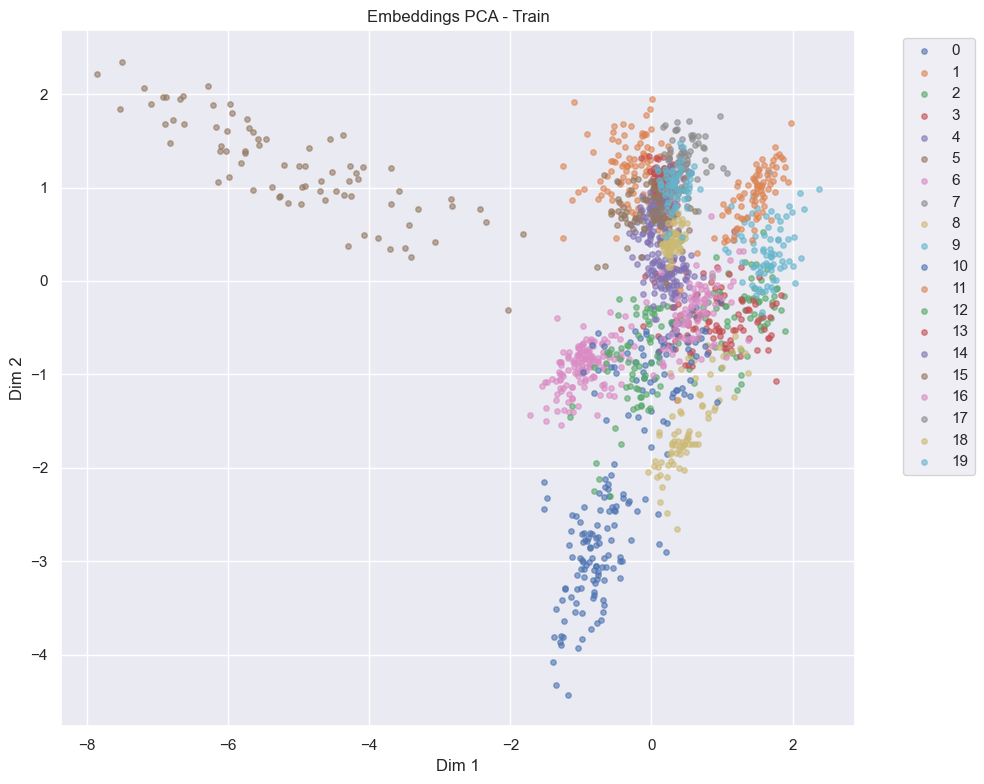

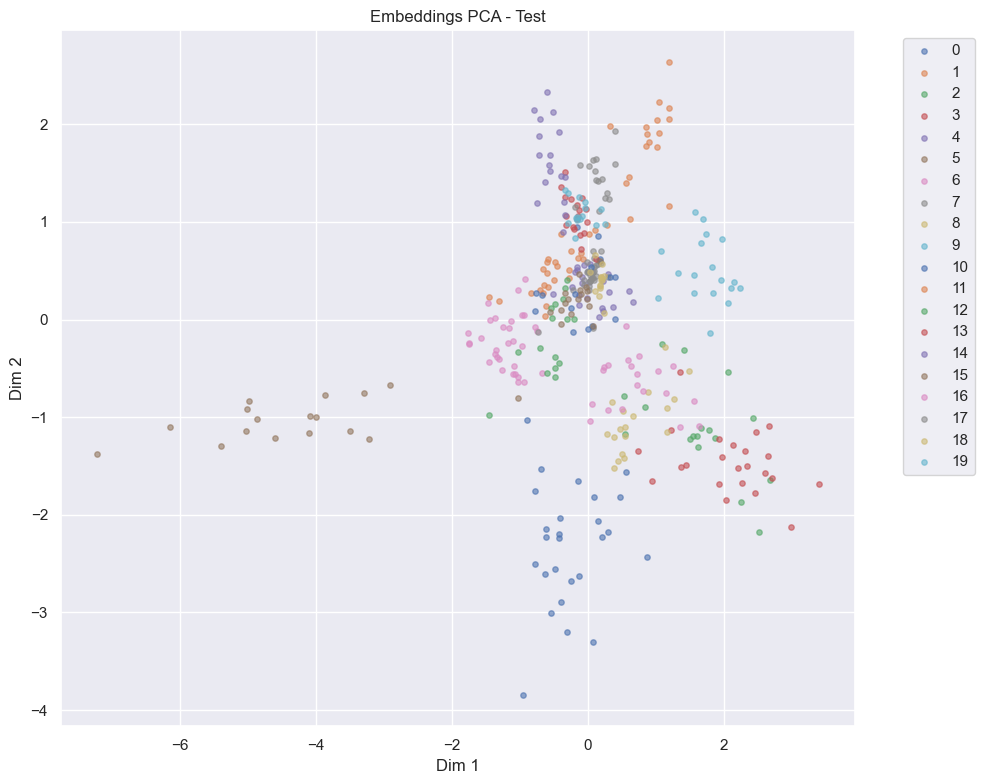

In [43]:
# ================================================================
# 6.1) VISUALIZAR EMBEDDINGS EN 2D
# ================================================================
def plot_embeddings(embeddings, labels, method="pca", title="Embeddings 2D"):
    """
    embeddings: np.array (N, embedding_dim)
    labels: np.array (N,)
    method: "pca" o "tsne"
    """
    if method.lower() == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        reducer = PCA(n_components=2)
        
    emb_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    num_classes = len(np.unique(labels))
    for c in range(num_classes):
        idx = labels == c
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=str(c), alpha=0.6, s=15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

# Visualizar embeddings de entrenamiento
plot_embeddings(train_emb, train_lbl, method="pca", title="Embeddings PCA - Train")

# Visualizar embeddings de test
plot_embeddings(test_emb, test_lbl, method="pca", title="Embeddings PCA - Test")

In [44]:
# ================================================================
# 7) XGBOOST PARA CLASIFICAR EMBEDDINGS
# ================================================================
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='mlogloss'
)

xgb.fit(train_emb, train_lbl)
xgb_preds = xgb.predict(test_emb)

acc_xgb = accuracy_score(test_lbl, xgb_preds)
f1_xgb  = f1_score(test_lbl, xgb_preds, average="macro")

print("🎯 XGBoost Accuracy:", acc_xgb)
print("🔥 XGBoost F1-score:", f1_xgb)

🎯 XGBoost Accuracy: 0.9670886075949368
🔥 XGBoost F1-score: 0.9687554652694471


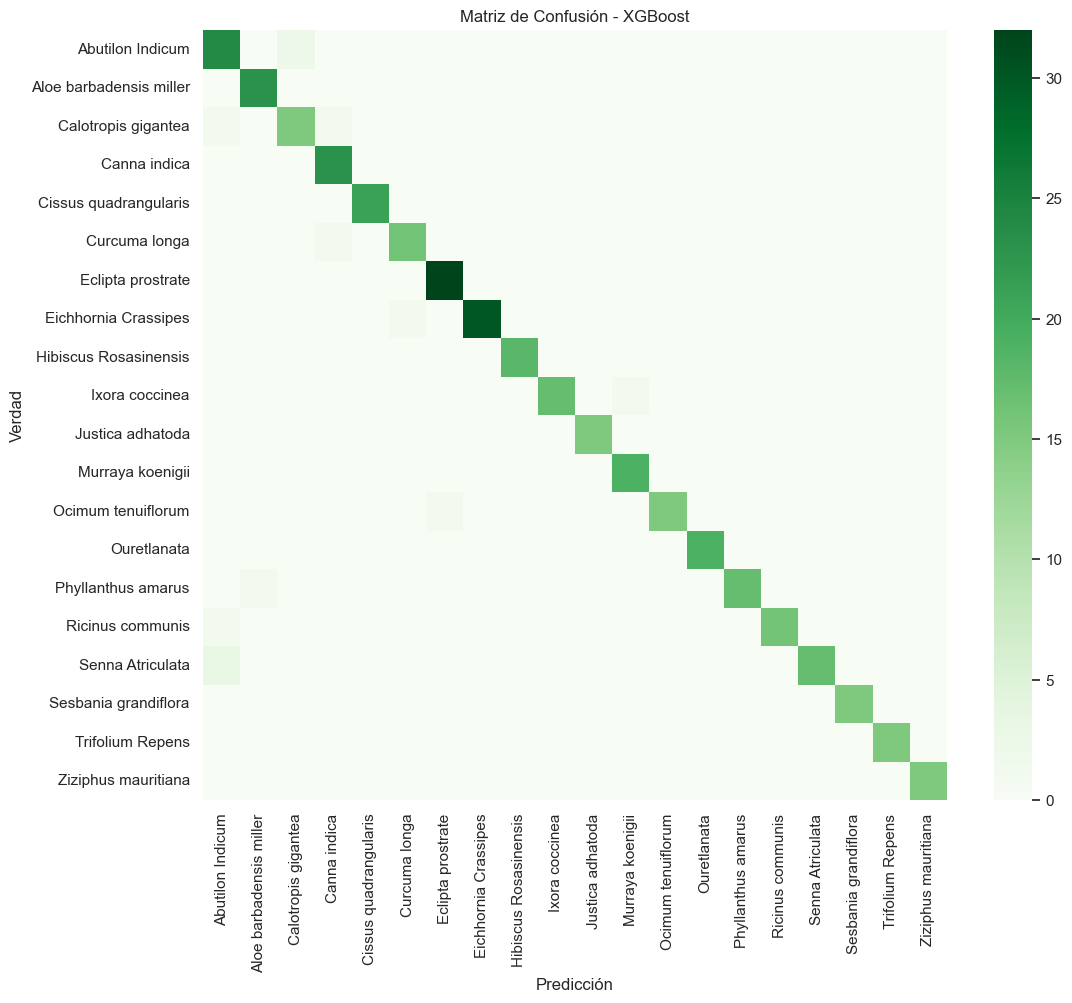

In [45]:
# ================================================================
# 8) MATRIZ DE CONFUSIÓN XGBOOST
# ================================================================
cm = confusion_matrix(test_lbl, xgb_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Verdad")
plt.show()

In [46]:
# ================================================================
# 9) GUARDAR MODELOS
# ================================================================
torch.save(siamese.state_dict(), "siamese_triplet_backbone.pth")
torch.save(classifier.state_dict(), "classifier_fc_triplet.pth")
xgb.save_model("xgboost_triplet.json")
print("✅ Modelos guardados en la carpeta del notebook")

✅ Modelos guardados en la carpeta del notebook
